# Data cleaning and analysis 
Here we're going to do data cleaning and analysis again. So for the situation, we're going to analyze a dataset about clothing. In this, we're going to do data cleaning again and then some EDA.



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
from IPython.display import display
import os

clothing_df = pd.read_csv("../../data/shoe_prices.csv")

# We'll setup some display settings

# Set up the maximum columns and rows 
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# Set the precision of floating point numbers 
pd.options.display.precision = 2 

warnings.filterwarnings('ignore') # ignore warnings.


In [18]:
'''
+ Data cleaning

1. Handling duplicate values: 6 rows are considered as duplicates. So that just means there are 6 rows whose entire columns match. 
You probably want to drop these rows, so in the end 3 rows will be dropped.
2. Handling missing values

'''
duplicate_rows = clothing_df[clothing_df.duplicated(keep=False)]

clothing_df = clothing_df.drop_duplicates()

# Create a series that shows the percentage of missing values in each column/series; 
# Only show the columns that have the percentages > 0, so we only see the columns that have missing values.
missing_value_percentages = (clothing_df.isnull().sum() / len(clothing_df) * 100).sort_values(ascending=False)
missing_value_percentages[missing_value_percentages > 0]

# Remove columns that are unnecessary
columns_to_delete = ['prices.count', 'prices.warranty', 'Unnamed: 49', 'Unnamed: 48', 'count', 'websiteIDs', 'vin', 'flavors',
               'isbn', 'Unnamed: 50', 'prices.flavor', 'prices.source', 'Unnamed: 51', 'prices.availability', 'dimension',
               'weight', 'prices.returnPolicy', 'asins', 'prices.shipping', 'reviews', 'prices.offer', 'sizes',
               'manufacturer', 'ean', 'upc', 'prices.condition', 'merchants', 'prices.size', 'prices.color', 'quantities',
               'skus', 'manufacturerNumber', 'dateAdded', 'dateUpdated', 'sourceURLs', 'keys', 'descriptions',
               'prices.sourceURLs', 'prices.dateAdded', 'prices.dateSeen', 'id', 'prices.merchant']


# Only keep columns that exist in the DataFrame; as a result, we'll be able to only delete the columns that exist
columns_to_delete = [col for col in columns_to_delete if col in clothing_df.columns]
clothing_df = clothing_df.drop(columns_to_delete, axis=1)


'''
+ Looking at the 'features' column. Let's analyze it
'[
  # Indicates the patterns of the piece of clothing, 
  # I think here it's a sweater. 
  {"key":"Pattern","value":["Solid"]},

  # The country it came from?
  {"key":"Worldstock Country","value":["Peru"]},

  # 'Neck style' of the 
  {"key":"Neck Style","value":["Scoop Neck"]},

  # And then obviously other information
  {"key":"Sleeve-length","value":["Long Sleeve"]},
  {"key":"Front","value":["Flat Front"]},
  {"key":"Care Instruction","value":["Hand Wash"]},
  {"key":"Closure","value":["Pull Over"]},
  {"key":"Dress Length","value":["Short"]},
  {"key":"Size","value":["L, M, S, XL"]},
  {"key":"Dimensions","value":["See Details"]},
  {"key":"Model Number","value":["231516"]},
  {"key":"material","value":["Acrylic, Alpaca Wool"]}
]'

However, there could be different keys such as 'Gender' for the piece of clothing.

'''
# Create a 'Gender' series; some rows have no gender key so those will have 'None' or a missing value 
clothing_df['Gender'] = clothing_df['features'].str.split('"key":"Gender","value":\["',
                                         expand=True)[1].str.split('"\]}',
                                                                   expand=True, n=1)[0]

# You can use this to see all possible values for the 'Gender' of some clothing
clothing_df['Gender'].unique()

# Filter out rows where Gender is 'Boys' or 'Men', then drop the 'Gender' column
clothing_df = clothing_df[~clothing_df['Gender'].isin(['Boys', 'Men'])]
clothing_df = clothing_df.drop('Gender', axis=1)


# We want to only have rows that are relating to shoes. So assume that regex
# works, and this gets all indices for rows. With true for values that aren't shoes and false for not.
# Then nan value in the case where the 'features' series value is nan so we can't do operations on it
idx_notshoe = clothing_df['features'].str.contains("socks|speaker|bluetooth|microphone|phone|india|patiala|cotton|wool|kid|junior|\
                            sweater|shirt|blouse|pedicure|kurta|kurti|tunic|handbag|bag|tote bag|purse|dress|legging|\
                            chain|hair accessories|hair clip|hair|claw|hair clamp|watch|bracelet|skirt|denim|sweatshirt|\
                            hoodie|top|sundress|robe|halloween|costume|pant|suit",
                                           flags=re.IGNORECASE)

# Fills any nan values with 'false'. We'll apply it to the series with inplace.
idx_notshoe.fillna(False, inplace=True)

# Locate all rows that are shoe related. Select all columns so that we keep an entire shoe 
# row if we find one.
clothing_df = clothing_df.loc[~idx_notshoe,:]

'''
Do the same idea as before but on the 'categories' column instead.
We'll filter out non-shoe rows.
'''
idx_notshoe = clothing_df['categories'].str.contains("socks|speaker|bluetooth|microphone|phone|india|patiala|cotton|wool|kid|\
                            junior|sweater|shirt|blouse|pedicure|kurta|kurti|tunic|handbag|bag|tote bag|purse|dress|\
                            legging|chain|hair accessories|hair clip|hair|claw|hair clamp|watch|bracelet|skirt|denim|\
                            sweatshirt|hoodie|top|sundress|robe|halloween|costume|pant|suit",
                                             flags=re.IGNORECASE)

idx_notshoe.fillna(False, inplace=True)
clothing_df = clothing_df.loc[~idx_notshoe,:]

'''
+ Handling missing values
1. Let's create a temporary column called 'colors2'. Here we extract the color value from the features column
2. Update the 'colors' series, so that any missing values are filled with the corresponding value in the 'colors2' series.
3. Drop colors2 since we don't need it anymore, and lowercase all values in the 'colors' series
4. Let's see the percentage of missing values in the 'colors' series

As a result, the amount of null values in the 'colors' series should be about 27.5% whereas before it was 41%
'''
clothing_df['colors2'] = clothing_df['features'].str.split('"key":"Color","value":\["',
                                         expand=True)[1].str.split('"\]}',
                                                                   expand=True, n=1)[0]
clothing_df['colors'] = clothing_df['colors'].fillna(clothing_df['colors2'])
clothing_df.drop('colors2', axis=1, inplace=True)
clothing_df['colors'] = clothing_df['colors'].str.lower()
clothing_df['colors'].isnull().sum()/33798*100

'''
+ Handling 'brand' series:

1. Handle missing values and lowercase all series values
2. Then we need to do a lot of remapping of values in the series. So assume we've done some research
and know the values we want to remap, and then we placed them all in this large 'brand_map' dictionary.

'''
clothing_df['brand'].fillna("Unbranded", inplace=True)
clothing_df['brand'] = clothing_df['brand'].str.lower() 

brand_map = {'a2 by aerosoles':'aerosoles', "what's what by aerosoles":'aerosoles',
'adidas outdoor':'adidas',
'adriana new york':'adriana',
'alexander mcqueen by puma':'puma', 'alexander mcqueen':'puma',
'alpine':'alpine swiss',
'anne klein ak':'anne klein', 'anne klein sport':'anne klein',
'annie shoes':'annie',
'athena':'athena alexander',
'babe.':'babe',
'baretraps':'bare traps',
'bcbg max azria':'bcbg', 'bcbg paris':'bcbg', 'bcbgeneration':'bcbg',
'beacon shoes':'beacon',
'bebe sport':'bebe', 'bebe stu':'bebe',
'belle by sigerson morrison':'belle', 'belle sigerson morrison':'belle',
'bernie mev':'bernie', 'bernie mev.':'bernie',
'bettye by bettye muller':'bettye muller', 'bettye by bettye muller ':'bettye muller',
"breckelle's":'breckelles',
'callaway footwear':'callaway',
'calvin klein ck':'calvin klein', 'calvin klein jeans':'calvin klein',
'carlos by carlos santana':'carlos santana',
'charles by charles david':'charels david',
'see by chloe':'chloe',
'clarks artisan':'clarks', 'clarks artisan collection':'clarks', 'clarks collection':'clarks',
'cobb hill by new balance':'new balance', 'cobb hill':'new balance',
'maria sharapova by cole haan': 'cole hann',
"corky's":'corkys', "corky's footwear":'corkys', "corkys footwear, inc.":'corkys',
'dearforms':'dearfoams', 'df by dearfoams':'dearfoams',
'derek lam 10 crosby':'derek lam',
'diba.true':'dibatrue',
'dolce&gabbana':'dolce and gabbana', 'dolce & gabbana':'dolce and gabbana', 'dolce by mojo moxy':'dolce and gabbana',
  'dolce vita':'dolce and gabbana', 'dv8 by dolce vita':'dolce and gabbana', 'dv by dolce vita':'dolce and gabbana',
"dr. scholl's":'dr scholls',
"dr. martens air wair":'drmartens',
'drew shoe':'drew',
'easy spirit e360':'easy spirit', 'easy spirit.':'easy spirit',
'ellie shoes':'ellie',
'emu australia':'emu',
'fergie footwear':'fergie',
'forever collectible':'forever', 'forever link':'forever', 'fourever funky':'forever',
'sarto by franco sarto':'franco sarto',
'ferriniusa':'ferrini',
'fitflop':'fit flop',
'funtasma by pleaser':'funtasma',
'g by guess':'guess',
'gc shoes':'gc',
'genuine grip footwear':'genuine grip',
"hogan by tod's":'hogan',
'soft style by hush puppies':'hush puppies',
'ilse jacobsen hornbaek':'ilse jacobson',
'isaacmizrahi':'isaac mizrahi',
'italian shoe makers':'italian comfort',
'j.renee':'j. renee',
'jbu by jambu':'jambu',
'josefseibel':'josef siebel',
'justin blair':'justin', 'justin boots':'justin', 'justin gypsy':'justin',
'kate spade new york':'kate spade',
'kenneth cole reaction':'kenneth cole', 'kenneth cole ny':'kenneth cole', 'kenneth cole new york':'kenneth cole',
 'unlisted kenneth cole':'kenneth cole',
'lamo sheepskin inc':'lamo',
'lifestride':'lifes tride',
'luoluo':'luo luo',
'marc fisher ltd':'marc fisher',
'mia heritage':'mia',
'micahel kors':'michael kors', 'michael michael kors':'michael kors',
'mobils by mephisto':'mephisto',
'top moda':'moda', 'moda essentials':'moda', 'everybody by bz moda':'moda',
'muk luks a la mode':'muk luks',
'munro american':'munro',
'naot footwear':'naot',
'new@titude':'new attitude', 'new@ttitude':'new attitude',
'nina originals':'nina',
'nine west vintage america collection':'nine west',
'nufoot���':'nufoot',
'pleaser shoes':'pleaser', 'pleaser usa, inc.':'pleaser', 'pleaserusa':'pleaser',
'rachel':'rachel roy', 'rachel rachel roy ':'rachel roy',
'lauren by ralph lauren':'ralph lauren', 'lauren ralph lauren':'ralph lauren', 'lauren lorraine':'ralph lauren',
 'polo ralph lauren':'ralph lauren','ralph lauren denim supply':'ralph lauren',
'rieker-antistress':'rieker',
'rocket dog brands llc':'rocket dog',
'sanita clogs':'sanita',
'ferragamo':'salvatore ferragamo',
'skechers usa':'skechers',
'sperry top sider':'sperry', 'sperry top-sider':'sperry',
"l'artiste by spring step":'spring step', "flexus by spring step":'spring step', "patrizia by spring step ":'spring step',
 "patrizia pepe":'spring step', "patrizia":'spring step',
'steven steve madden':'steve madden',
'style & co.':'style and co',
'timberland earthkeepers':'timberland', 'timberland pro':'timberland',
'toms shoes':'toms',
'tony lama boot co.':'tony lama',
'totes isotoner':'totes',
'trotter':'trotters',
'ugg australia':'ugg',
'famous name brand':'unbranded', 'generic':'unbranded', 'generic surplus':'unbranded', 'non-branded':'unbranded',
 'not applicable':'unbranded', 'not rated':'unbranded', 'lucky  brand':'unbranded', 'lucky brand':'unbranded',
 'very fine dance shoes':'unbranded',
'valentino noir':'valentino',
'victoria k.':'victoria',
'vince camuto':'vince',
'vionic by orthaheel':'vionic', 'vionic with orthaheel technology':'vionic',
'elites by walking cradles':'walking cradles', 'elites':'walking cradles','mark lemp by walking cradles':'walking cradles',
 'rose petals by walking cradles':'walking cradles', 'the walking cradle company':'walking cradles'
}

# Create new series called 'brand_clean' which has the remapped brand names
clothing_df['brand_clean'] = clothing_df['brand'].replace(brand_map)
clothing_df['brand_clean'].head(5)

# Let's say we also want to delete some rows that have certain brand names
brands_to_delete = ['1 world sarongs', 'mirage pet products', 'timeless toys'] # to delete
clothing_df = clothing_df[~clothing_df['brand'].isin(brands_to_delete)]

# Group our shoes by the brand
brands_group = clothing_df.groupby('brand')

# For each group, select the highest prices for each row, and get the average value.
# As a result, we can get teh average value our most expensive brands.
brands_group['prices.amountMax'].mean().sort_values(ascending=False).head(10)

# The brand 'jewelobsession' isn't shoe-related, so we'll exclude them from our dataframe.
clothing_df = clothing_df[~(clothing_df['brand'] == 'jewelobsession')]

# We can also look at the unexpensive/generic brands, and honestly they're still quite expensive in my eyes
clothing_df[clothing_df['brand'] == 'unbranded'].sort_values(by='prices.amountMax', ascending=False)[['name','prices.amountMax']].head()

'''
+ Alright let's continue with some data-cleaning tasks:
1. Delete the first 3 'unbranded' rows when doing 'descending order'. As a result 
we'd delete the 3 most expensive unbranded rows. We'll get back a series of row index values
2. Removing the rows from the dataframe
3. The brand 'teva' has some errors. Let's remove its first two rows 
'''
idx1 = clothing_df[clothing_df['brand'] == 'unbranded'].sort_values(by='prices.amountMax', ascending=False).head(3).index
clothing_df.drop(idx1, axis=0, inplace=True)

idx2 = clothing_df[clothing_df['brand'] == 'teva'].sort_values(by='prices.amountMax', ascending=False).head(2).index
clothing_df.drop(idx2, axis=0, inplace=True)

'''
have tried to categorize the type of shoe from the categories column:

1. isBoots: Boots, calf
2. isBooties: booties, heel, wedge, pumps
3. isSlipper: sandal, gladiator, flip-flop, slipper, slide
4. isAthletic: athletic, basketball, golf, sport, running, training, gym, fitness, climb, soccer, hiking, outdoor
5. isCasual: casual, contemporary, sneakers, slip-on, mules, moccasion, flats, espadrille, loafers
6. isDesigner: designer
7. isLeather: A leather shoe
8. isOther: None of the Above

So let's create some columns to help us out
'''

'''
Create a series of boolean values on whether it matches our regex or not.
Then convert the boolean values into 1 or 0 values for the 'isBoots' series.
Show the distribution (in percents) for all of the different values

Let's do this for all 7 categories. Create 7 new columns that allow us to easily 
work with different categories.
'''
clothing_df['isBoots'] = clothing_df['categories'].str.contains('Boot|calf', flags=re.IGNORECASE).map(lambda x: 1 if (x == True) else 0)
clothing_df['isBooties'] = clothing_df['categories'].str.contains("booties|bootie|heel|wedge|pump|Stiletto",
                                                flags=re.IGNORECASE
                                               ).map(lambda x:1 if(x==True) else 0)
clothing_df['isSandal'] = clothing_df['categories'].str.contains("sandal|gladiator|flip|flop|slipper|slide",
                                                flags=re.IGNORECASE
                                                ).map(lambda x:1 if(x==True) else 0)
clothing_df['isAthletic'] = clothing_df['categories'].str.contains("athletic|basketball|golf|sport|run|running|trainin|gym|fitness|climb|\
                                    soccer|outdoor|hiking|hike|skecher|balance|fila|asics|Easy Spirit|trainer|adidas|puma|\
                                    reebok|nike",
                                                 flags=re.IGNORECASE
                                                 ).map(lambda x:1 if(x==True) else 0)
clothing_df['isCasual'] = clothing_df['categories'].str.contains("casual|contemporary|sneaker|slip-on|clog|round|toe|converse|canvas|mule|\
                                    moccasin|flat|Bahama|espadrille|loafer",
                                                 flags=re.IGNORECASE
                                                 ).map(lambda x:1 if(x==True) else 0)
clothing_df['isDesigner'] = clothing_df['categories'].str.contains("design",
                                                 flags=re.IGNORECASE
                                                 ).map(lambda x:1 if(x==True) else 0)
clothing_df['isLeather'] = clothing_df['categories'].str.contains("leather|pu|patent",
                                                 flags=re.IGNORECASE
                                                 ).map(lambda x:1 if(x==True) else 0)
'''
Create another column 'isOther'. So 'clothing_df[typeOfShoe] will select the columns
from the DataFrame in typeOfShoe. Each of these columns contains 1 (for True) if the shoe is of that 
type and 0 (for False) if it is not.

Sum the values across the columns for each row, with axis=1 specifying that this summing happens
horizontally (across the columns) for each individual row. If a shoe belongs to multiple types such 
as isBoots and isCasual both being true, it's going to be greater than 1. Else if it doesn't belong to 
any type then the sum will be zero.

Finally in our map, if the summed result (from the series) is 0, which means it belongs to none of the main categories, then
we return 1 to indicate that 'isOther' is true. Else return 0 since the summed result is greater than 0.

In summary, creates a 'isOther' column that marks the rows where the shoe does not belong to any of the types listed 
in typeOfShoe!
'''
typeOfShoe = ['isBoots', 'isBooties', 'isSandal', 'isAthletic', 'isCasual', 'isDesigner', 'isLeather']
clothing_df['isOther'] = (clothing_df[typeOfShoe].sum(axis=1)).map(lambda x:1 if(x==0) else 0)

'''
+ Unit Conversion: Let's convert all prices to USD!
So convert the 'prices.amountMin' and 'prices.amountMax' for all of your rows. You'd use loc for this and 
the typical strategy used in the main notes.
'''
clothing_df.loc[clothing_df['prices.currency'] == 'CAD', 'prices.amountMin'] = clothing_df['prices.amountMin'] / 1.35
clothing_df.loc[clothing_df['prices.currency'] == 'CAD', 'prices.amountMax'] = clothing_df['prices.amountMax'] / 1.35
clothing_df.loc[clothing_df['prices.currency'] == 'EUR', 'prices.amountMin'] = clothing_df['prices.amountMin'] / 0.9
clothing_df.loc[clothing_df['prices.currency'] == 'EUR', 'prices.amountMax'] = clothing_df['prices.amountMax'] / 0.9
clothing_df.loc[clothing_df['prices.currency'] == 'AUD', 'prices.amountMin'] = clothing_df['prices.amountMin'] / 1.46
clothing_df.loc[clothing_df['prices.currency'] == 'AUD', 'prices.amountMax'] = clothing_df['prices.amountMax'] / 1.46
clothing_df.loc[clothing_df['prices.currency'] == 'GBP', 'prices.amountMin'] = clothing_df['prices.amountMin'] / 0.79
clothing_df.loc[clothing_df['prices.currency'] == 'GBP', 'prices.amountMax'] = clothing_df['prices.amountMax'] / 0.79

## Reviewing our data cleaning steps
Let's review the main data cleaning steps that we took to clean our data.
1. Deleted duplicate values.
2. Handled missing values, or most of them anyways by removing unnecessary columns.
3. Created new columns by deriving information based on other columns For example, we created a lot of the boolean columns like `isAthletic`, `isBoots`, etc.
4. Filtering so we only get shoe-related data
5. Handling missing values in the 'colors' series
6. Remapped some values in the 'brand' series. We handled missing values and turned them into 'Unbranded' and all column values were converted to lowercase.
7. Created boolean columns to see what category a piece of clothing fell into.
8. Made sure units were uniform by converting all prices into USD.


## EDA (Exploratory Data Analysis)
Again let's dip our toes into the idea of exploratory data analysis.



In [ ]:
# Get a series of the brands with the most expensive average price; get the index values, so just the names of the brands
top50 = clothing_df.groupby('brand_clean')['prices.amountMax'].mean().sort_values(ascending=False).head(50).index

# Get all products associated with those brrands
df50 = clothing_df.loc[clothing_df['brand_clean'].isin(top50)]

'''
- data: Accepts the DataFrame
- order: So the order the top50 is in, the barplot will be in 
On the y axis of the bar plot, we;ll have the brand names, whilst x axis will measure the amounts. 
This'll make sense when you see it, as this is a horizontal barplot.
'''
plt.figure(figsize=(12,20))
sns.barplot(y='brand_clean', x='prices.amountMax', data=df50, order=top50)

'''
Data can be kind of skewed as many of these brands only have one record. Let's see the top50 brands that have 
at least 5 records. So let's get all rows that meet these conditions
'''
dfmin5records = clothing_df[clothing_df['brand_clean'].isin(
  # This should return a list of brand names with at least 5 rows
  list((clothing_df['brand_clean'].value_counts() >= 5).index)  
)]

# Get a list of those typically most expensive brand names again
newTop50 = list(dfmin5records.groupby('brand_clean')['prices.amountMax'].mean().sort_values(ascending=False).head(50).index)

# Get all rows associated with those brand names
newDF50 = dfmin5records.loc[dfmin5records['brand_clean'].isin(newTop50)]

sns.barplot(y='brand_clean', x='prices.amountMax', data=newDF50, order=newTop50)

<Axes: title={'center': 'Price distribution of all the shoes with value more than $250.'}, xlabel='prices.amountMax', ylabel='Density'>

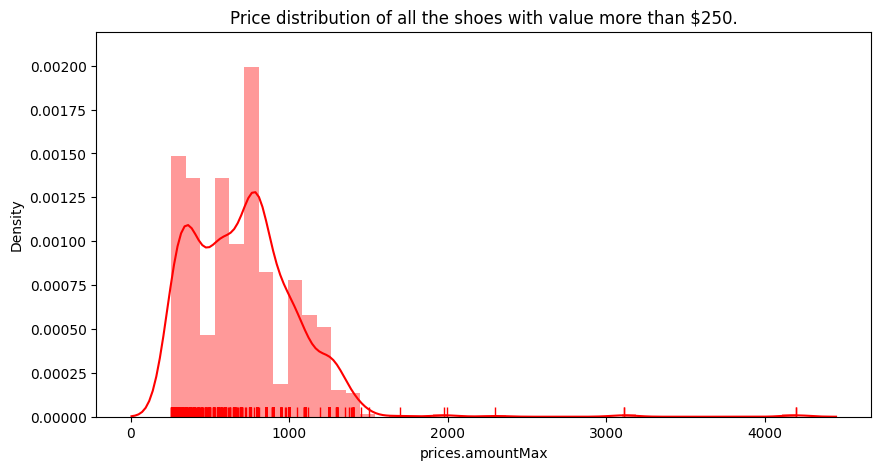

In [35]:
''' 
Most of the shoes in this dataset range from 0 to 250 dollars.
'''

plt.figure(figsize=(10,5))
plt.title("Price distribution of all shoes")
# sns.distplot(clothing_df['prices.amountMax'], rug=True, color='green')


# Almost a normal distribution, but has a right skew
plt.title('Price distribution of all the shoes with value less than $250.')
# sns.distplot(clothing_df[clothing_df['prices.amountMax'] <= 250]['prices.amountMax'], rug=True)

plt.title('Price distribution of all the shoes with value more than $250.')
sns.distplot(clothing_df[clothing_df['prices.amountMax'] > 250]['prices.amountMax'], rug=True, color='red')

<Axes: xlabel='range', ylabel='brand_clean'>

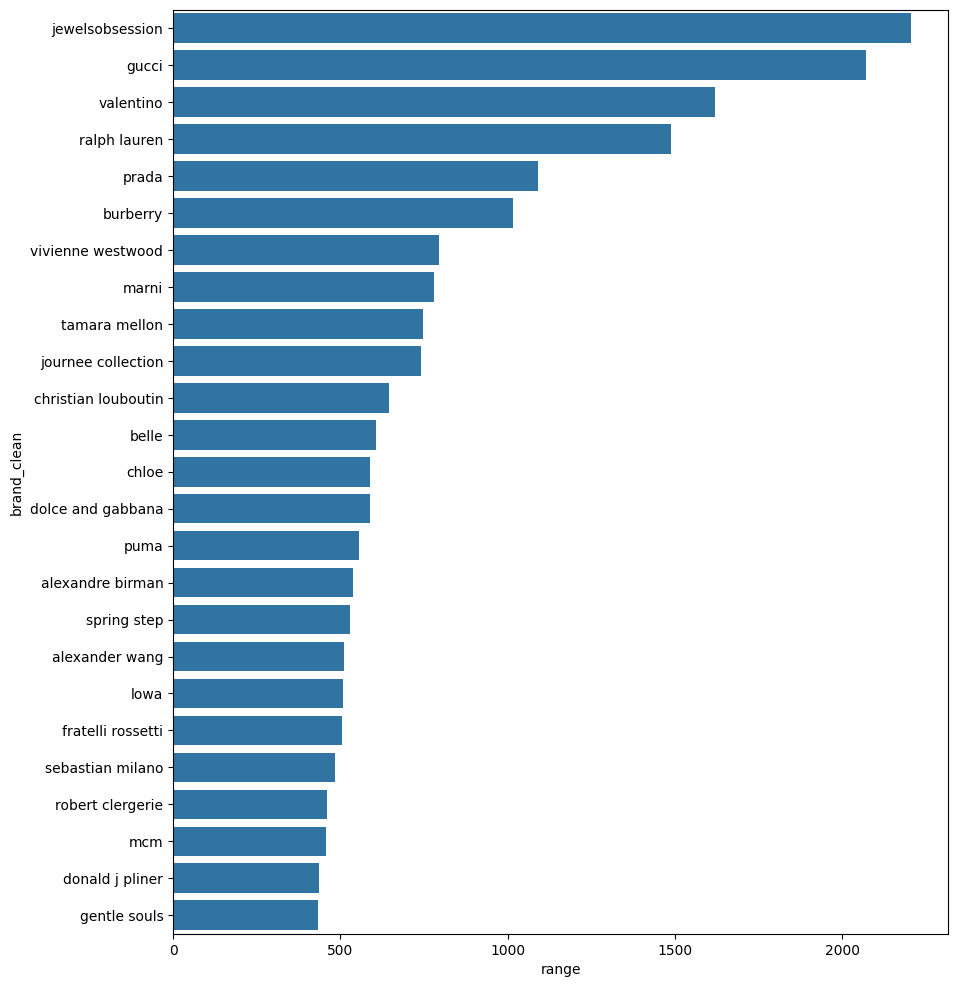

In [38]:
# Get the minimum and maximum price for each brand. So throughout all of their products, get their cheapest and most expensive prices.
priceRange = clothing_df.groupby('brand_clean')['prices.amountMax'].agg({'min','max'})

# Create a new column that has the range value
priceRange['range'] = priceRange['max'] - priceRange['min']

# Get the 25 most expensive rows
top25priceRange = priceRange.sort_values(by='range', ascending=False)[0:25]

plt.figure(figsize=(10,12))
sns.barplot(y=top25priceRange.index, x=top25priceRange.range)
